In [1]:
import numpy as np
import pandas as pd
import pprint
import matplotlib.pyplot as plt
import pandas_profiling as pdp

from sklearn.preprocessing import LabelEncoder, StandardScaler

import lightgbm as lgb
from sklearn.svm import SVR
# model tensorflow
import tensorflow as tf
from keras.callbacks import EarlyStopping
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.layers.normalization import BatchNormalization
from keras.layers.advanced_activations import ReLU, PReLU
from keras.optimizers import SGD, Adam
from sklearn.linear_model import Ridge

from functools import partial
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials, space_eval
from sklearn.model_selection import KFold, cross_validate
from sklearn.metrics import mean_squared_error as MSE, make_scorer

import pickle
import datetime

In [39]:
train = pd.read_csv('../data/input/train.csv')
test = pd.read_csv('../data/input/test.csv')
sample_sub = pd.read_csv('../data/input/sample_submit.csv', header=None, names=['id', 'mpg'])

train_test = pd.concat([train, test], ignore_index=True, sort=False)

In [40]:
train_test['car name'] = train_test['car name'].str.replace('vw', 'volkswagen')
train_test['car name'] = train_test['car name'].str.replace('vokswagen', 'volkswagen')
train_test['car name'] = train_test['car name'].str.replace('toyouta', 'toyota')
train_test['car name'] = train_test['car name'].str.replace('chevy', 'chevrolet')
train_test['car name'] = train_test['car name'].str.replace('datsun 200-sx', 'datsun 200sx')

train_test['car name'] = train_test['car name'].str.replace('datsun 210 mpg', 'datsun 210')
train_test['car name'] = train_test['car name'].str.replace('ford gran torino (sw)', 'ford gran torino')

#train_test['car_brand'] = train_test['car name'].apply(lambda x: x.strip().split(' ')[0])

In [41]:
train_test['horsepower'].replace('?', np.nan, inplace=True)
train_test['horsepower'] = train_test['horsepower'].astype(float)

In [42]:
cat_cols = ['car name']#, 'car_brand']
for cols in cat_cols:
    train_test[cols] = LabelEncoder().fit_transform(train_test[cols])

display(train_test)

,id,mpg,cylinders,displacement,horsepower,weight,acceleration,model year,origin,car name
0,0,23.059782,6,140,110.0,2815,17.977429,80,1,33
1,3,17.674521,8,350,150.0,4456,13.514535,72,1,39
2,4,17.136353,8,302,140.0,2774,13.209912,79,1,59
3,7,22.664666,6,400,85.0,2190,15.196381,71,1,72
4,9,17.872018,8,429,220.0,2245,9.621400,70,1,47
...,...,...,...,...,...,...,...,...,...,...
995,992,NaN,4,225,105.0,3870,15.376311,76,1,21
996,993,NaN,4,140,112.0,2720,13.616843,82,1,9
997,996,NaN,8,318,110.0,2774,13.272636,75,1,51
998,998,NaN,4,90,75.0,2807,17.792560,77,1,37


In [43]:
#hp_train_test = train_test.drop(['id', 'mpg'], axis=1)
hp_train_test = train_test.drop(['id'], axis=1)
test_x = hp_train_test[hp_train_test['horsepower'].isnull()].drop(['horsepower'], axis=1)
hp_train = hp_train_test.dropna(subset=['horsepower'], axis=0)
train_y = hp_train['horsepower'].copy()
train_x = hp_train.drop(['horsepower'], axis=1)

display(train_x)
pprint.pprint(train_y)
display(test_x)

,mpg,cylinders,displacement,weight,acceleration,model year,origin,car name
0,23.059782,6,140,2815,17.977429,80,1,33
1,17.674521,8,350,4456,13.514535,72,1,39
2,17.136353,8,302,2774,13.209912,79,1,59
3,22.664666,6,400,2190,15.196381,71,1,72
4,17.872018,8,429,2245,9.621400,70,1,47
...,...,...,...,...,...,...,...,...
995,NaN,4,225,3870,15.376311,76,1,21
996,NaN,4,140,2720,13.616843,82,1,9
997,NaN,8,318,2774,13.272636,75,1,51
998,NaN,4,90,2807,17.792560,77,1,37


0      110.0
1      150.0
2      140.0
3       85.0
4      220.0
       ...  
995    105.0
996    112.0
997    110.0
998     75.0
999     69.0
Name: horsepower, Length: 985, dtype: float64


,mpg,cylinders,displacement,weight,acceleration,model year,origin,car name
10,44.763897,4,85,1755,17.503013,80,2,74
48,23.008702,4,140,1760,19.472427,76,1,84
224,28.146944,4,140,1760,19.420540,76,1,84
286,44.021790,4,85,1955,20.795175,80,2,71
320,44.410105,4,85,1955,21.057837,80,2,71
407,28.048825,4,140,1760,19.139558,71,1,84
415,28.079580,4,140,1760,17.268393,82,1,84
455,27.536418,4,140,1760,19.243466,76,1,84
487,27.725048,4,140,1760,19.532434,76,1,84
598,NaN,4,85,4274,20.917523,78,2,53


# Define Functions

In [11]:
class Model1_LGBM:

    def __init__(self, params):
        self.params = params
        self.params['max_depth'] = int(self.params['max_depth'])
        self.params['num_leaves'] = int(self.params['num_leaves'])
        #self.params['min_data_in_leaf'] = int(self.params['min_data_in_leaf'])
        self.model = lgb.LGBMRegressor(**self.params)

    def fit(self, tr_x, tr_y, va_x, va_y):
        self.model.fit(tr_x, tr_y)

    def predict(self, x):
        return self.model.predict(x)

In [12]:
class Model1_RF:
    
    def __init__(self, params):
        params['n_estimators'] = int(params['n_estimators'])
        params['max_depth'] = int(params['max_depth'])
        params['min_samples_split'] = int(params['min_samples_split'])
        
        self.params = params
        self.model = RandomForestRegressor(**self.params)
        
    def fit(self, tr_x, tr_y, va_x, va_y):
        self.model.fit(tr_x, tr_y)
    
    def predict(self, x):
        return self.model.predict(x)

In [13]:
class Model1_SVR:
    def __init__(self, params):
        self.params = params
        self.model = SVR(**self.params)

    def fit(self, tr_x, tr_y, va_x, va_y):
        self.model.fit(tr_x, tr_y)
    
    def predict(self, x):
        return self.model.predict(x)

In [14]:
# 線形モデル
class Model2_Ridge:

    def __init__(self, params):
        self.params = params
        self.model = Ridge(**self.params)
        self.scaler = None

    def fit(self, tr_x, tr_y, va_x, va_y):
        #self.scaler = StandardScaler()
        #self.scaler.fit(tr_x)
        #tr_x = self.scaler.transform(tr_x)
        self.model.fit(tr_x, tr_y)

    def predict(self, x):
        #x = self.scaler.transform(x)
        #pred = self.model.predict(x)
        return self.model.predict(x)

In [15]:
def RMSE(y_true, y_pred):
    return(np.sqrt(MSE(y_true, y_pred)))

def objective(x, y, args):  
    if args['model_type'] == 'lgb':
        del args['model_type']
        reg = Model1_LGBM(args)
    elif args['model_type'] == 'svr':
        del args['model_type']
        reg = Model1_SVR(args)
    elif args['model_type'] == 'nn':
        del args['model_type']
        reg = Model1_NN(args)
    elif args['model_type'] == 'rid':
        del args['model_type']
        reg = Model2_Ridge(args)
    elif args['model_type'] == 'rf':
        del args['model_type']
        reg = Model1_RF(args)
    elif args['model_type'] == 'et':
        del args['model_type']
        reg = Model1_ET(args)
    else:
        del args['model_type']
        reg = None

    scores = []
    
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    for tr_idx, va_idx in kf.split(x, y):
        tr_x = x.iloc[tr_idx]
        tr_y = y.iloc[tr_idx]
        va_x = x.iloc[va_idx]
        va_y = y.iloc[va_idx]
        
        reg.fit(tr_x, tr_y, va_x, va_y)        
        va_pred = reg.predict(va_x)
        score = RMSE(va_y, va_pred)
        scores.append(score)
        
    return {
        'loss': np.mean(scores),
        'status':STATUS_OK,
        'params':args
    }

In [18]:
def show_trials(trials):
    result = [(i['loss'], i['params']) for i in sorted(trials.results, key=lambda x:x['loss'])]
    params_df = pd.concat(
        [pd.Series([i[0] for i in result], name='loss'),
        pd.DataFrame([i[1] for i in result])],
        axis=1
    )
    params_df.iloc[:100].plot.line(
        figsize=(20, 60), marker='o', subplots=True, legend=True, grid=True
    )
    plt.show()

# Averaging
calculate average horsepower form same car name group

In [16]:
name_hp_mean = train_test.groupby('car name').horsepower.mean()
df_hp_isnull = train_test[train_test['horsepower'].isnull()]

temp = train_test.copy()
# nan位置のtrainデータのhorse powerを置換する
for i in df_hp_isnull.index:
    temp.loc[i, 'horsepower'] = name_hp_mean[df_hp_isnull.loc[i, 'car name']]

display(temp.loc[df_hp_isnull.index])

,id,mpg,cylinders,displacement,horsepower,weight,acceleration,model year,origin,car name
10,24,44.763897,4,85,95.333333,1755,17.503013,80,2,74
48,96,23.008702,4,140,85.923077,1760,19.472427,76,1,84
224,454,28.146944,4,140,85.923077,1760,19.420540,76,1,84
286,574,44.021790,4,85,97.878788,1955,20.795175,80,2,71
320,645,44.410105,4,85,97.878788,1955,21.057837,80,2,71
407,815,28.048825,4,140,85.923077,1760,19.139558,71,1,84
415,831,28.079580,4,140,85.923077,1760,17.268393,82,1,84
455,901,27.536418,4,140,85.923077,1760,19.243466,76,1,84
487,970,27.725048,4,140,85.923077,1760,19.532434,76,1,84
598,206,NaN,4,85,82.920000,4274,20.917523,78,2,53


# HyperOpt

## LightGBM

In [44]:
params_lgb = {
    'model_type': 'lgb',
    'alpha' : hp.loguniform(label='alpha', low=np.log(1e-8), high=np.log(0.1)),
    'bagging_fraction': hp.quniform(label='bagging_fraction', low=0.4, high=0.80, q=0.05),
    'feature_fraction': hp.quniform(label='feature_fraction', low=0.4, high=0.9, q=0.05),
    'gamma': hp.quniform(label='gamma', low=0.1, high=0.9, q=0.1),
    'lambda' : hp.loguniform(label='lambda', low=np.log(1e-6), high=np.log(0.6)),
    'max_depth': hp.quniform(label='max_depth', low=5, high=13, q=1),
    'min_child_weight': hp.quniform(label='min_child_weight', low=1, high=10, q=1),
    #'min_data_in_leaf': hp.quniform(label='min_data_in_leaf', low=5, high=10, q=2),
    'num_leaves': hp.quniform(label='num_leaves', low=5, high=30, q=10)
}

f_lgb = partial(objective, train_x, train_y)
trials_lgb = Trials()

best_lgb = fmin(
    fn=f_lgb,
    space=params_lgb,
    algo=tpe.suggest,
    trials=trials_lgb,
    max_evals=500
)

100%|██████████████████████████████████████████████| 500/500 [01:35<00:00,  5.23trial/s, best loss: 22.572615124866793]


best_params:
{'alpha': 0.056292182836669535,
 'bagging_fraction': 0.6000000000000001,
 'feature_fraction': 0.6000000000000001,
 'gamma': 0.30000000000000004,
 'lambda': 0.1366839144101436,
 'max_depth': 6.0,
 'min_child_weight': 10.0,
 'num_leaves': 30.0}


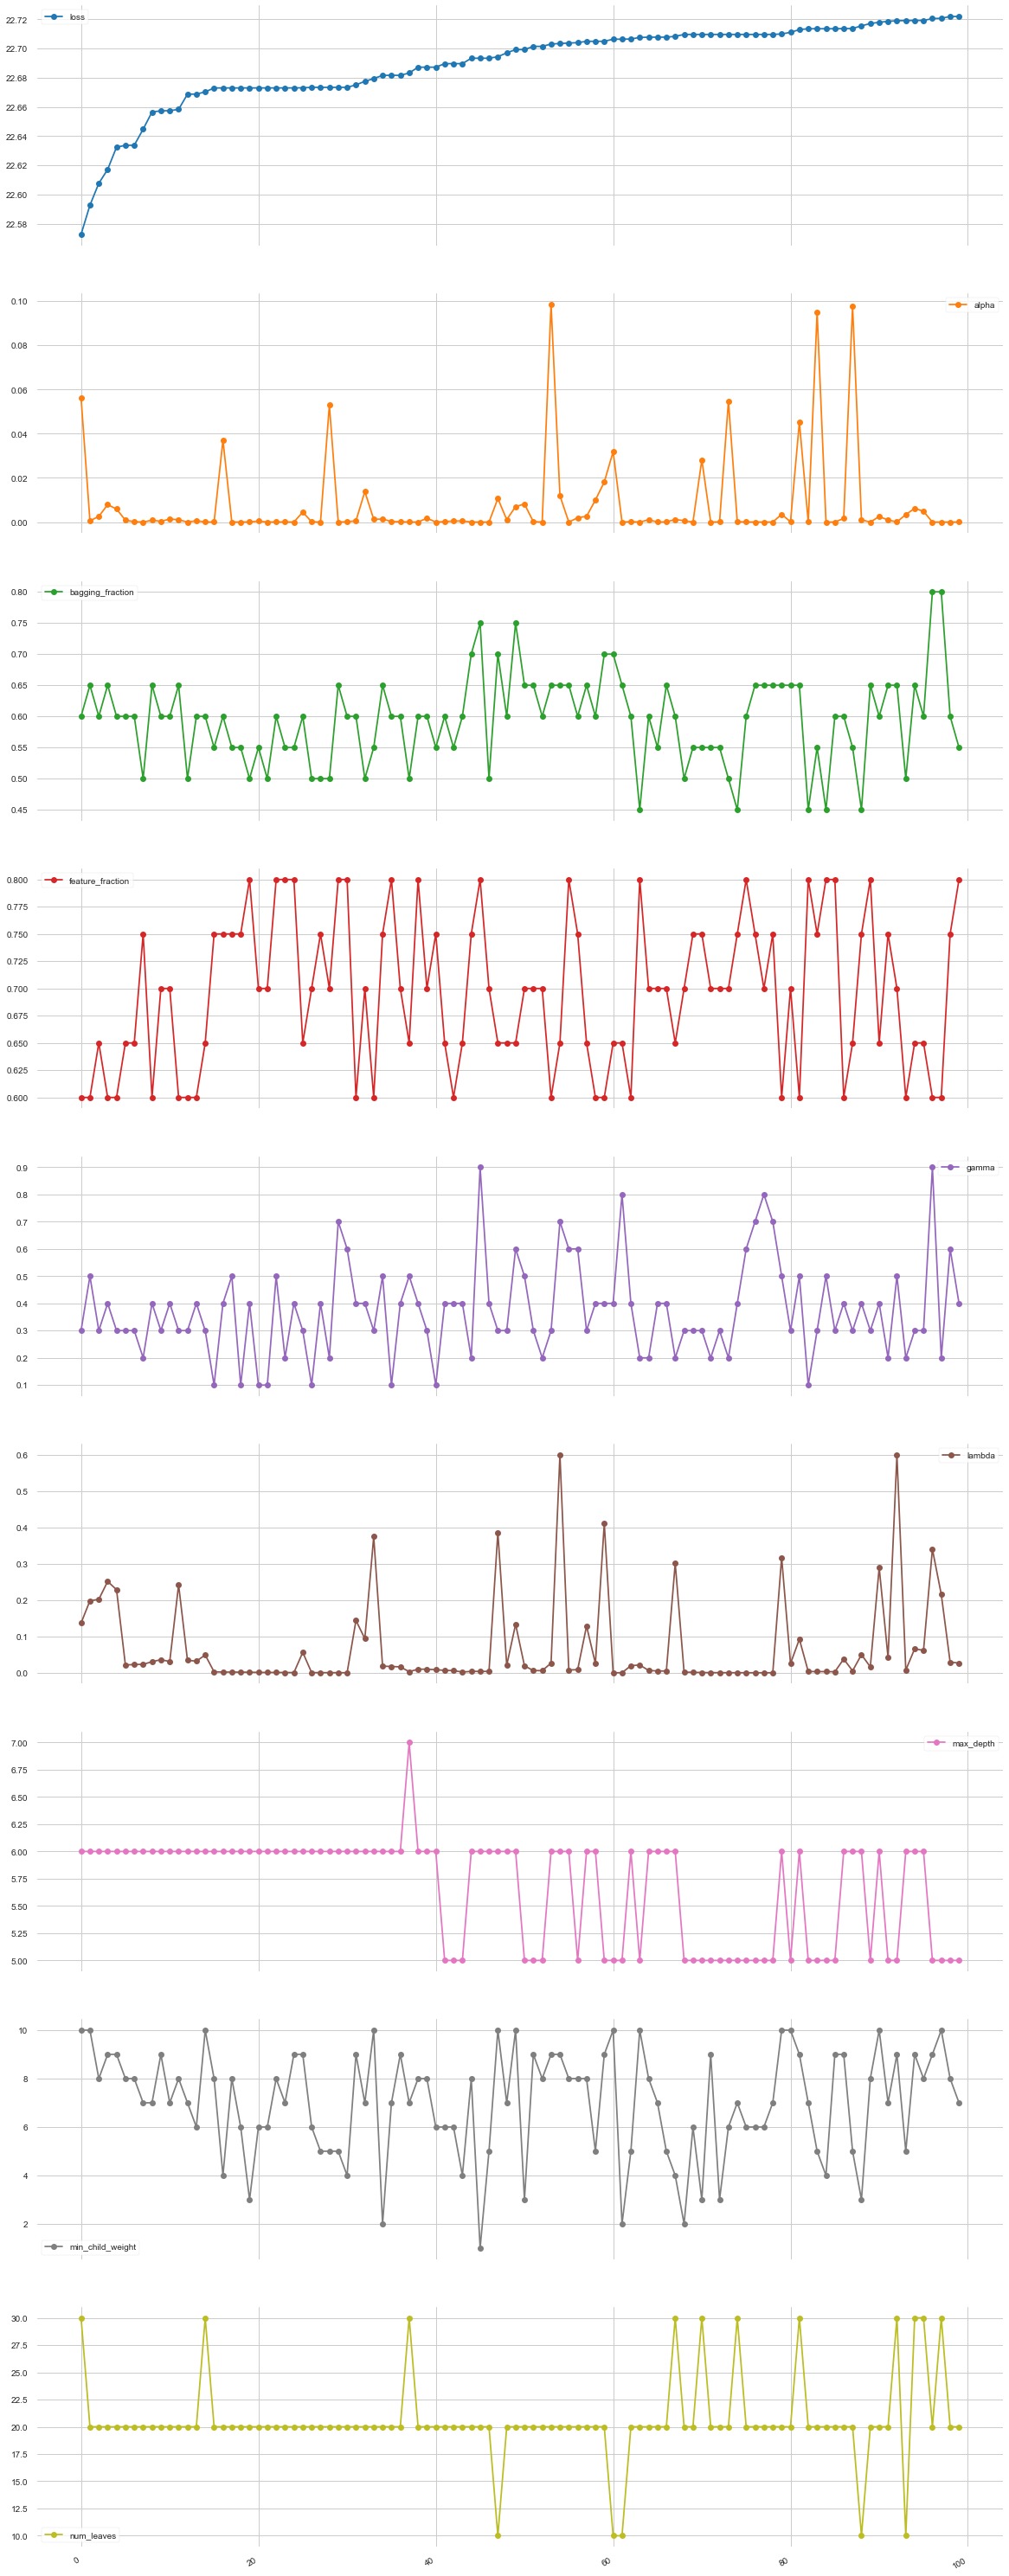

In [45]:
print('best_params:')
pprint.pprint(best_lgb)
show_trials(trials_lgb)

# SVR

In [46]:
# One Hot Encoding
cat_cols = ['cylinders', 'model year', 'origin', 'car name']#, 'car_brand']
train_test_svr = pd.get_dummies(
    train_test,
    columns=cat_cols, 
    sparse=False
)

# StandardScaler
cols = ['displacement', 'horsepower', 'acceleration']
scaler = StandardScaler(copy=True, with_mean=True, with_std=True)
train_test_svr[cols] = scaler.fit_transform(train_test_svr[cols])

train_test_svr = train_test_svr.drop(['id', 'mpg'], axis=1)
test_x_svr = train_test_svr[train_test_svr['horsepower'].isnull()].drop(['horsepower'], axis=1).copy()
train_x_svr = train_test_svr.dropna(subset=['horsepower'], axis=0).drop(['horsepower'], axis=1).copy()

In [47]:
params_svr = {
    'model_type': 'svr',
    'kernel': 'rbf',
    'C': hp.loguniform(
        label='C', low=np.log(1), high=np.log(30)
    ),
    'epsilon':hp.loguniform(
        label='epsilon', low=np.log(0.5), high=np.log(1.5)
    ),
    'gamma': hp.loguniform(
        label='gamma', low=np.log(0.01), high=np.log(0.3)
    )
}

f_svr = partial(objective, train_x_svr, train_y)
trials_svr = Trials()

best_svr = fmin(
    fn=f_svr,
    space=params_svr,
    algo=tpe.suggest,
    trials=trials_svr,
    max_evals=500
)

100%|██████████████████████████████████████████████| 500/500 [04:17<00:00,  1.94trial/s, best loss: 25.345463114699257]


best_params:
{'C': 16.022677917391565,
 'epsilon': 1.4750305912115982,
 'gamma': 0.23762689477288979}


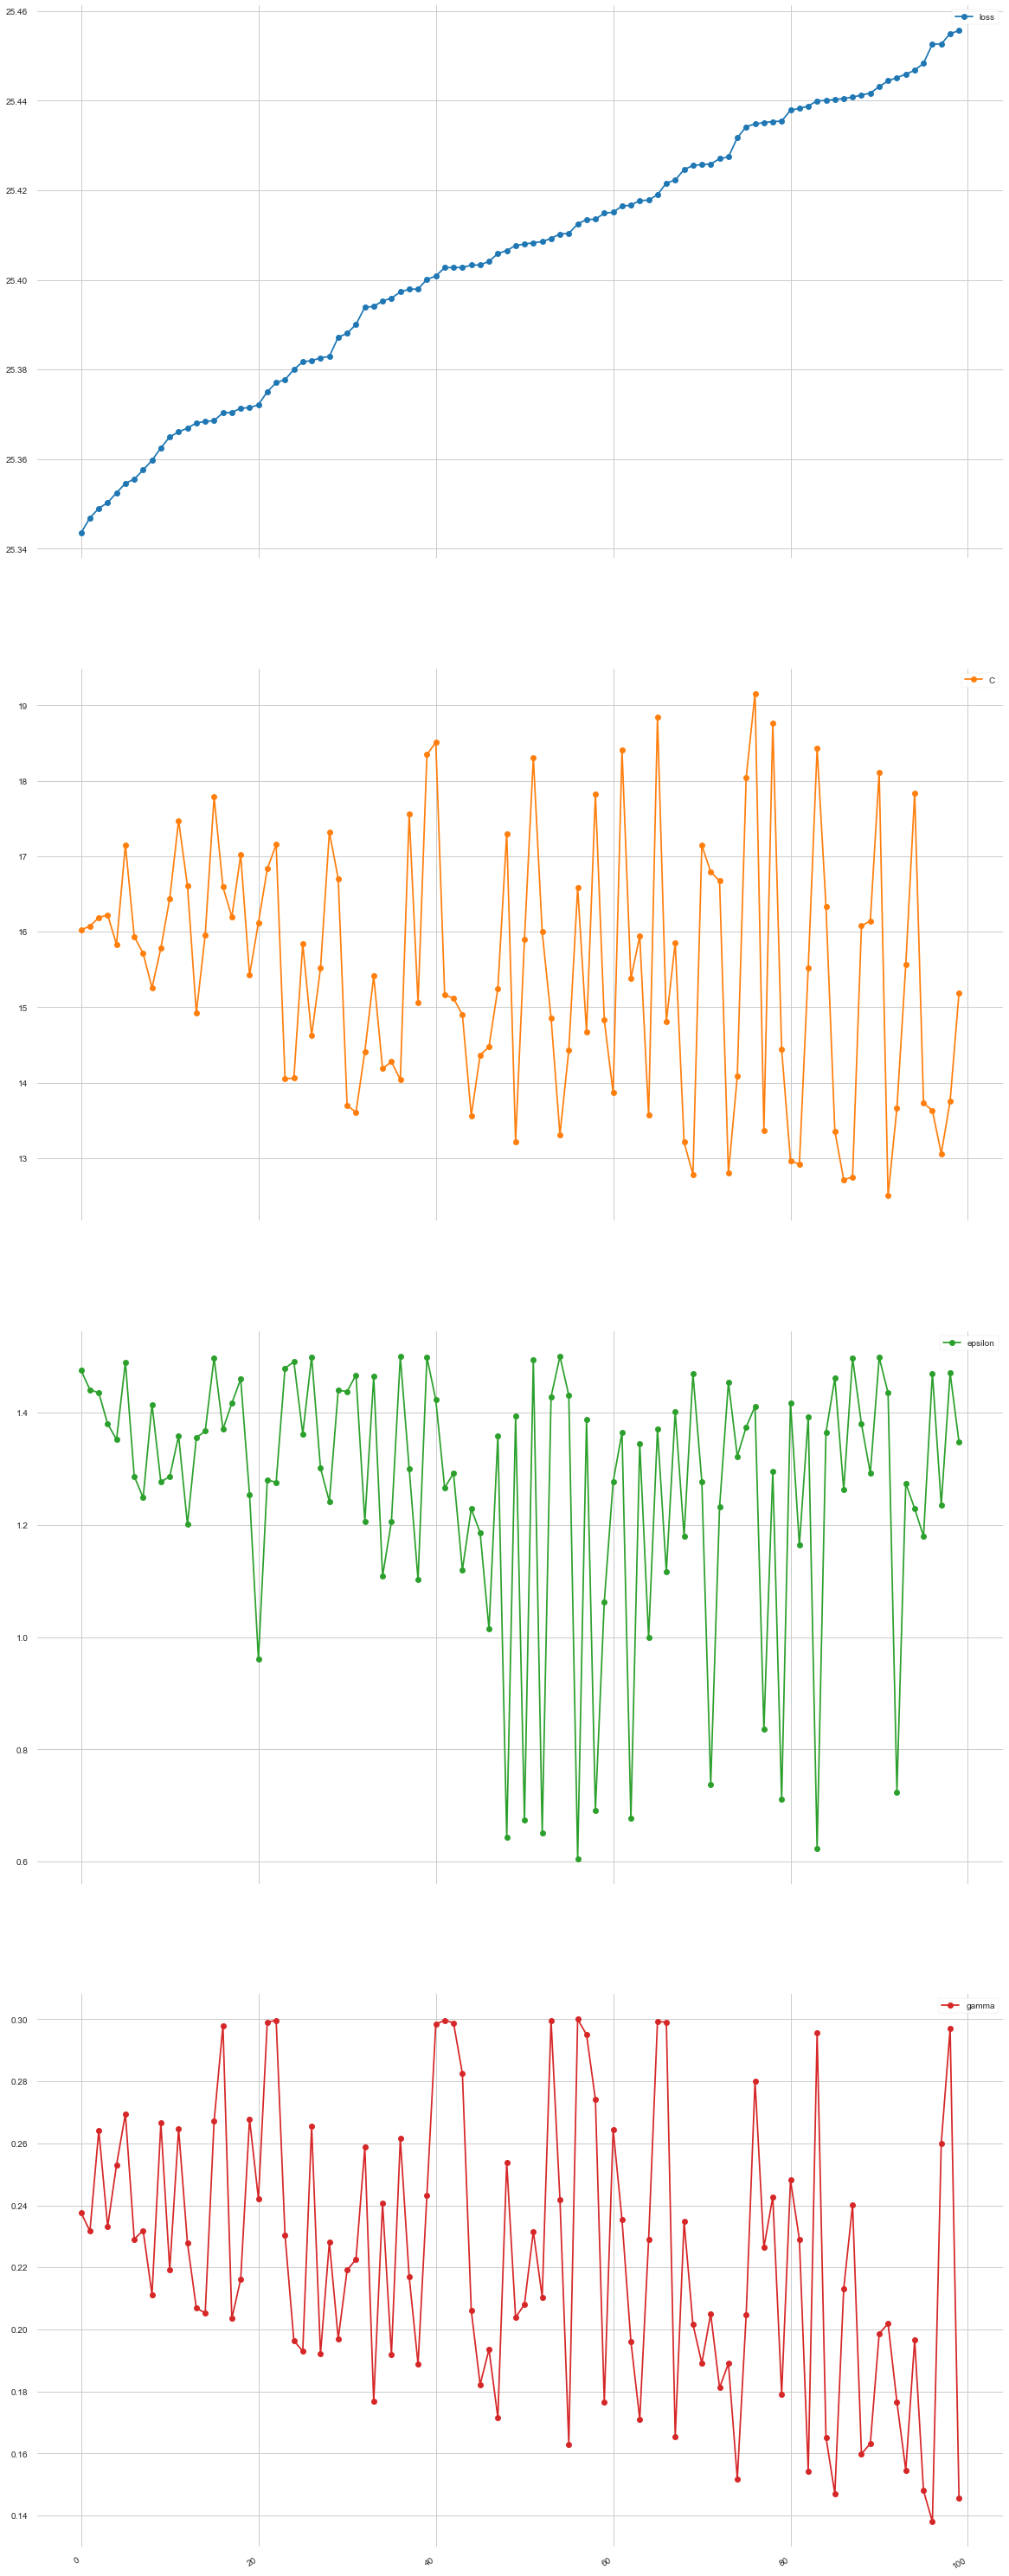

In [22]:
print('best_params:')
pprint.pprint(best_svr)
show_trials(trials_svr)

# Stacking

In [23]:
def predict_cv(model, train_x, train_y, test_x):
    preds = []
    preds_test = []
    va_idxes = []
    
    kf = KFold(n_splits=5, shuffle=True, random_state=0)
    
    for i, (tr_idx, va_idx) in enumerate(kf.split(train_x)):
        tr_x, va_x = train_x.iloc[tr_idx], train_x.iloc[va_idx]
        tr_y, va_y = train_y.iloc[tr_idx], train_y.iloc[va_idx]
        
        model.fit(tr_x, tr_y, va_x, va_y)
        pred = model.predict(va_x)
        preds.append(pred)
        
        pred_test = model.predict(test_x)
        preds_test.append(pred_test)
        
        va_idxes.append(va_idx)
    
    va_idxes = np.concatenate(va_idxes)
    preds = np.concatenate(preds, axis=0)
    order = np.argsort(va_idxes)
    pred_train = preds[order]
    
    preds_test = np.mean(preds_test, axis=0)
    
    return pred_train, preds_test

In [48]:
model_1a = Model1_LGBM(params=best_lgb)
model_1b = Model1_SVR(params=best_svr)

pred_train_1a, pred_test_1a = predict_cv(model_1a, train_x, train_y, test_x)
pred_train_1b, pred_test_1b = predict_cv(model_1b, train_x_svr, train_y, test_x_svr)

In [49]:
score_1a = RMSE(train_y, pred_train_1a)
score_1b = RMSE(train_y, pred_train_1b)
print(f'model_1a(lgb) score: {score_1a:.4f}')
print(f'model_1b(svr) score: {score_1b:.4f}')

model_1a(lgb) score: 23.0200
model_1b(svr) score: 26.7118


In [50]:
# 予測値を特徴量としてデータフレームを作成
train_x_2 = pd.DataFrame({
    'pred_1a(lgb)': pred_train_1a, 
    'pred_1b(svr)': pred_train_1b,
})
test_x_2 = pd.DataFrame({
    'pred_1a(lgb)': pred_test_1a,
    'pred_1b(svr)': pred_test_1b,
})
display(train_x_2)
display(test_x_2)

,pred_1a(lgb),pred_1b(svr)
0,108.878884,109.654725
1,157.288079,148.529516
2,136.333831,138.534064
3,90.636688,99.902019
4,183.671161,145.269935
...,...,...
980,95.808094,105.463708
981,117.542081,107.783988
982,130.465061,117.618110
983,97.624320,98.395512


,pred_1a(lgb),pred_1b(svr)
0,83.703139,93.896110
1,78.946011,73.220268
2,81.410336,73.277692
3,73.844506,93.146408
4,73.962259,93.222249
5,87.071106,71.535077
6,109.257572,84.978910
7,79.455736,73.532493
8,83.446786,73.163662
9,84.094822,84.018685


## HyperOpt Ridge

In [51]:
params_rid ={
    'model_type': 'rid',
    'alpha': hp.quniform(label='alpha', low=1, high=30, q=1),
}
max_evals = 50
trials_rid = Trials()
f_rid = partial(objective, train_x_2, train_y)

best_rid = fmin(
    fn=f_rid, 
    space=params_rid, 
    algo=tpe.suggest, 
    trials=trials_rid,
    max_evals=max_evals
)

100%|█████████████████████████████████████████████████| 50/50 [00:00<00:00, 58.55trial/s, best loss: 23.00603557386002]


best_params:
{'alpha': 1.0}


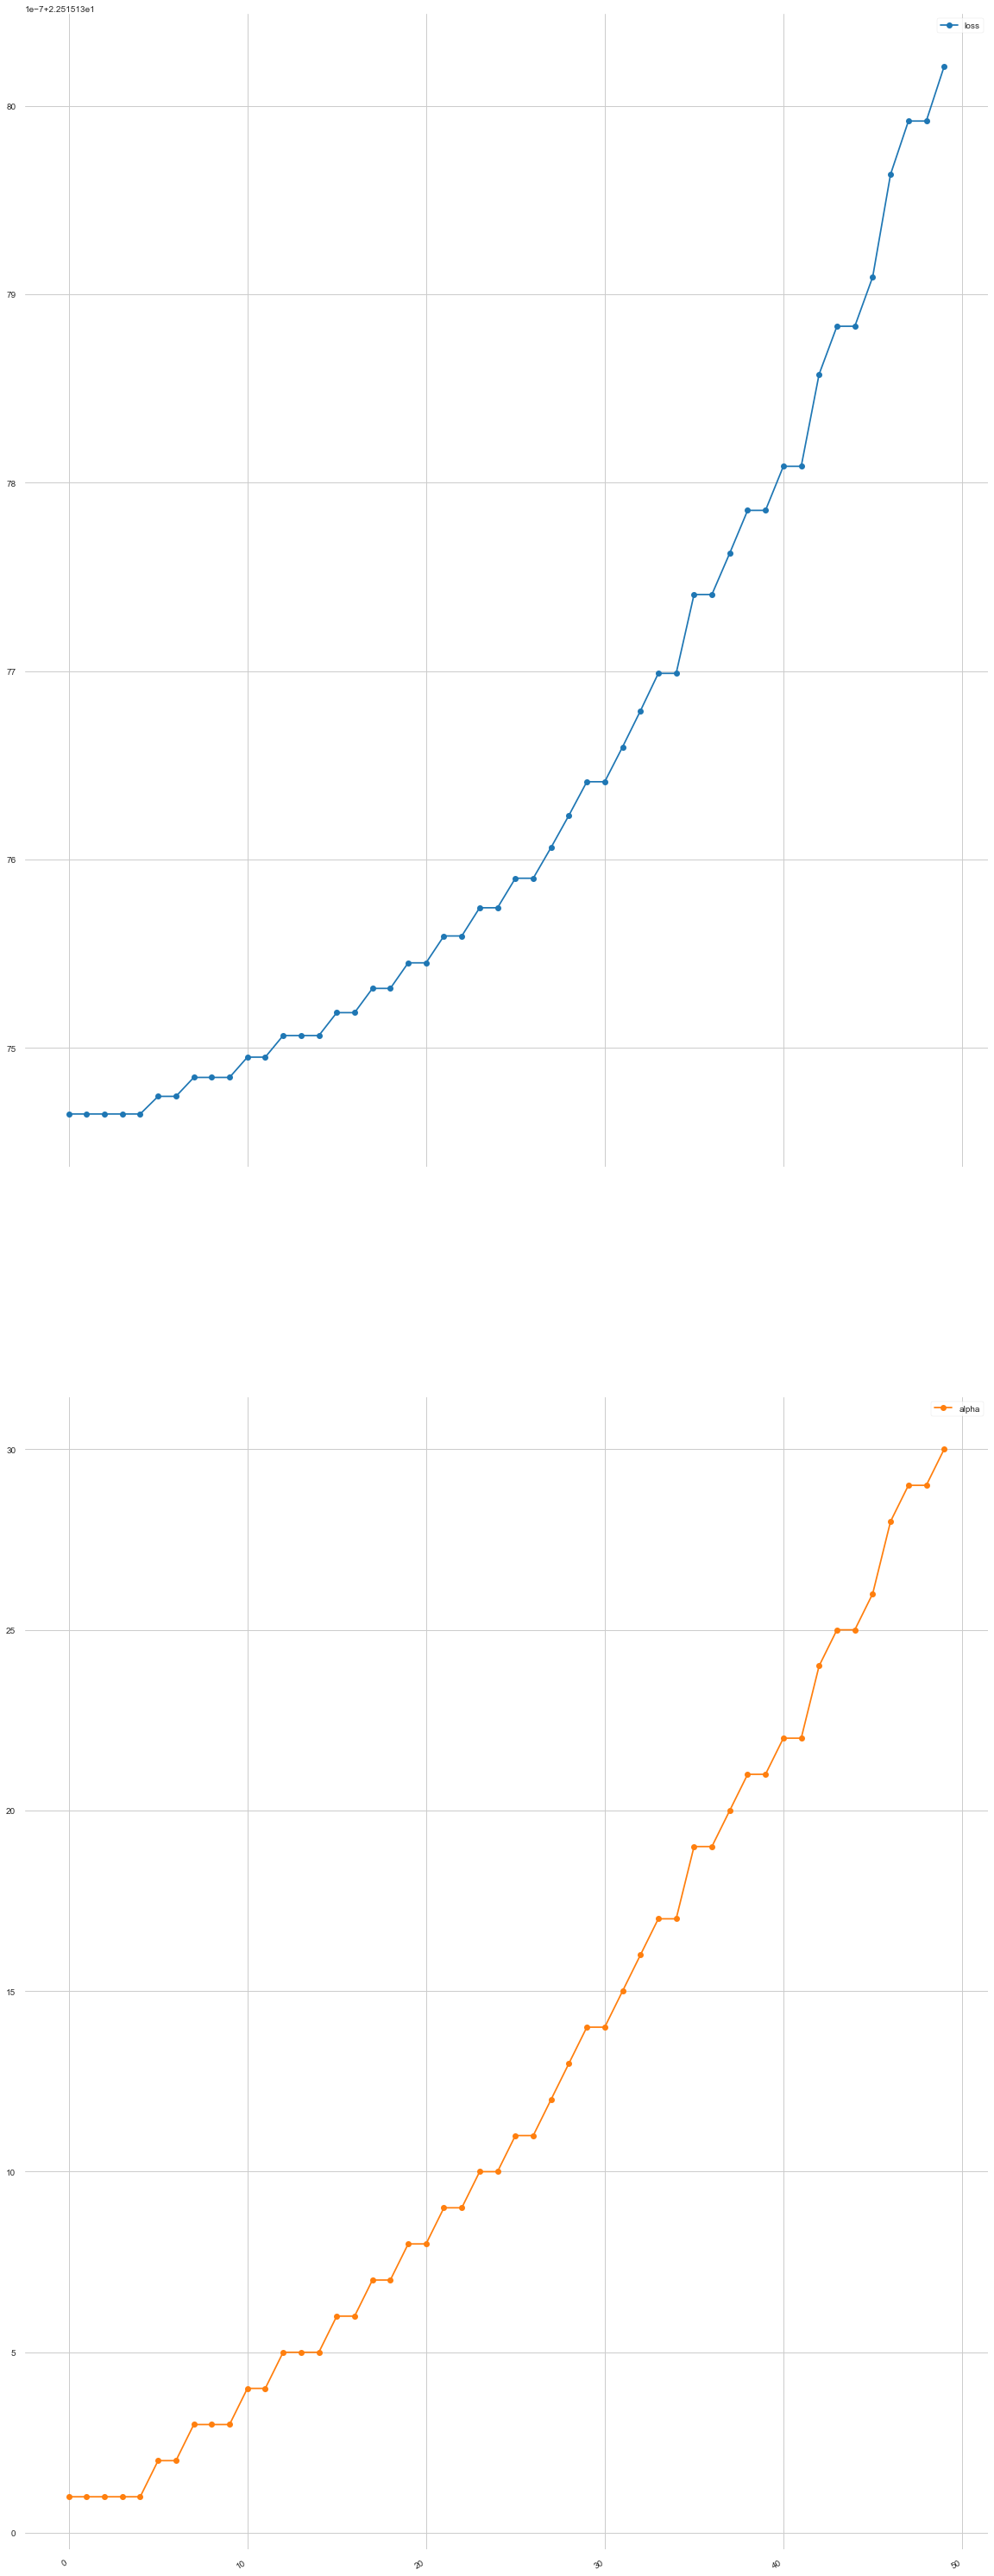

In [31]:
print('best_params:')
pprint.pprint(best_rid)
show_trials(trials_rid)

In [52]:
model_2 = Model2_Ridge(params=best_rid)
pred_train_2, pred_test_2 = predict_cv(model_2, train_x_2, train_y, test_x_2)
score_2 = RMSE(train_y, pred_train_2)
print(f'score: {score_2:.4f}')

score: 23.1446


In [53]:
pred_test_2

array([ 84.16676102,  80.57363578,  83.07694855,  74.1834892 ,
        74.2987003 ,  88.94023829, 110.6987324 ,  81.07332583,
        85.15534803,  85.1604135 ,  90.40148423,  87.89983463,
        92.4004508 ,  82.92375055,  75.19066598])

In [54]:
temp.loc[df_hp_isnull.index, 'horsepower']

10     95.333333
48     85.923077
224    85.923077
286    97.878788
320    97.878788
407    85.923077
415    85.923077
455    85.923077
487    85.923077
598    82.920000
681    97.878788
881    85.923077
887    85.923077
907    95.333333
935    85.923077
Name: horsepower, dtype: float64

In [55]:
train_test.loc[train_test['horsepower'].isnull(), 'horsepower'] = pred_test_2

In [56]:
train_test.loc[df_hp_isnull.index]

,id,mpg,cylinders,displacement,horsepower,weight,acceleration,model year,origin,car name
10,24,44.763897,4,85,84.166761,1755,17.503013,80,2,74
48,96,23.008702,4,140,80.573636,1760,19.472427,76,1,84
224,454,28.146944,4,140,83.076949,1760,19.420540,76,1,84
286,574,44.021790,4,85,74.183489,1955,20.795175,80,2,71
320,645,44.410105,4,85,74.298700,1955,21.057837,80,2,71
407,815,28.048825,4,140,88.940238,1760,19.139558,71,1,84
415,831,28.079580,4,140,110.698732,1760,17.268393,82,1,84
455,901,27.536418,4,140,81.073326,1760,19.243466,76,1,84
487,970,27.725048,4,140,85.155348,1760,19.532434,76,1,84
598,206,NaN,4,85,85.160414,4274,20.917523,78,2,53


In [57]:
dt = datetime.datetime.now().strftime('%Y-%m-%d-%H-%M-%S')
train_test['horsepower'] = train_test['horsepower'].astype(float)
train_test.to_pickle('../features/feature_train_test_' + dt + '_reg_horsepower.pickle')

In [4]:
best_score_1a = pickle.load(open('../logs/train_score_2020-11-22-11-22-28_stack_1a_lgb.pickle', 'rb'))
print(f'model_1a(lgb) score: {best_score_1a:.4f}')
best_score_1b = pickle.load(open('../logs/train_score_2020-11-22-11-22-28_stack_1b_svr.pickle', 'rb'))
print(f'model_1b(svr) score: {best_score_1b:.4f}')
best_score_1d = pickle.load(open('../logs/train_score_2020-11-22-11-22-28_stack_1d_rf.pickle', 'rb'))
print(f'model_1a(rf) score: {best_score_1d:.4f}')
best_score_2 = pickle.load(open('../logs/train_score_2020-11-22-11-22-28_stack_2_ridge.pickle', 'rb'))
print(f'model_2(rid) score: {best_score_2:.4f}')

model_1a(lgb) score: 2.9336
model_1b(svr) score: 3.7334
model_1a(rf) score: 2.9865
model_2(rid) score: 2.8757
